In [31]:
import pandas as pd
from top2vec import Top2Vec
import umap
import hdbscan
from functions import scatter_plot
import networkx
import matplotlib.pyplot as plt
from tqdm import tqdm
from functions import *

In [32]:
# Load your data in
data = pd.read_csv("all_abstracts.tsv", sep="\t")

In [33]:
data["pubdate"] = data["pubdate"].astype(str).str[0:4]
data = data[pd.to_numeric(data["pubdate"], errors = "coerce").notnull()]
data = data.dropna(subset=["pubdate"])
data["pubdate"] = data["pubdate"].astype(float)
data = data.dropna(subset=["pubdate"])
data = data.sort_values("pubdate")
data = data.reset_index()
print("TOTAL RECORDS:" + str(len(data)))

TOTAL RECORDS:3898


In [34]:
documents = data["combined"].tolist()

In [35]:
# Load our preconfigured Top2Vec Model
model = Top2Vec.load("models/top2vec_d2v")
# Train top2vec over our documents, you can specify the speed of learning with the speed parameter
# You can also assign the number of cores to use, Top2Vec will not use gpu so use this wisely!
#model = Top2Vec(documents,speed="fast-learn", workers=8)
# Once complete, save your model somewhere!
# If we want to load the model again, we can just use the following:
# model = Top2Vec.load("models/top2vec_d2v")
#model.save("models/top2vec_d2v")

Number of Topics Identified:4

ID of each topic: 
[0 1 2 3]
Number of Documents in each Topic: 
[3535  148  109  106]
[['this' 'paper' 'to' 'and' 'with' 'for' 'are' 'is' 'of' 'the' 'be' 'it'
  'which' 'these' 'into' 'most' 'that' 'abstract' 'them' 'providing' 'on'
  'can' 'in' 'however' 'used' 'their' 'provide' 'they' 'approach' 'from'
  'have' 'using' 'based' 'focus' 'at' 'new' 'its' 'specific' 'all'
  'developed' 'currently' 'by' 'also' 'use' 'effective' 'when' 'certain'
  'implementing' 'through' 'important']
 ['thinking' 'disciplinary' 'uk' 'date' 'ud' 'produced' 'http'
  'developers' 'version' 'programmes' 'mapping' 'he' 'description'
  'programme' 'keywords' 'spaces' 'higher' 'author' 'outline' 'phase'
  'issue' 'workshop' 'final' 'university' 'evaluating' 'last' 'subject'
  'enhanced' 'at' 'change' 'feedback' 'education' 'overview' 'within'
  'part' 'project' 'co' 'classroom' 'introduction' 'technologies' 'com'
  'around' 'journal' 'resources' 'australian' 'experience' 'resource

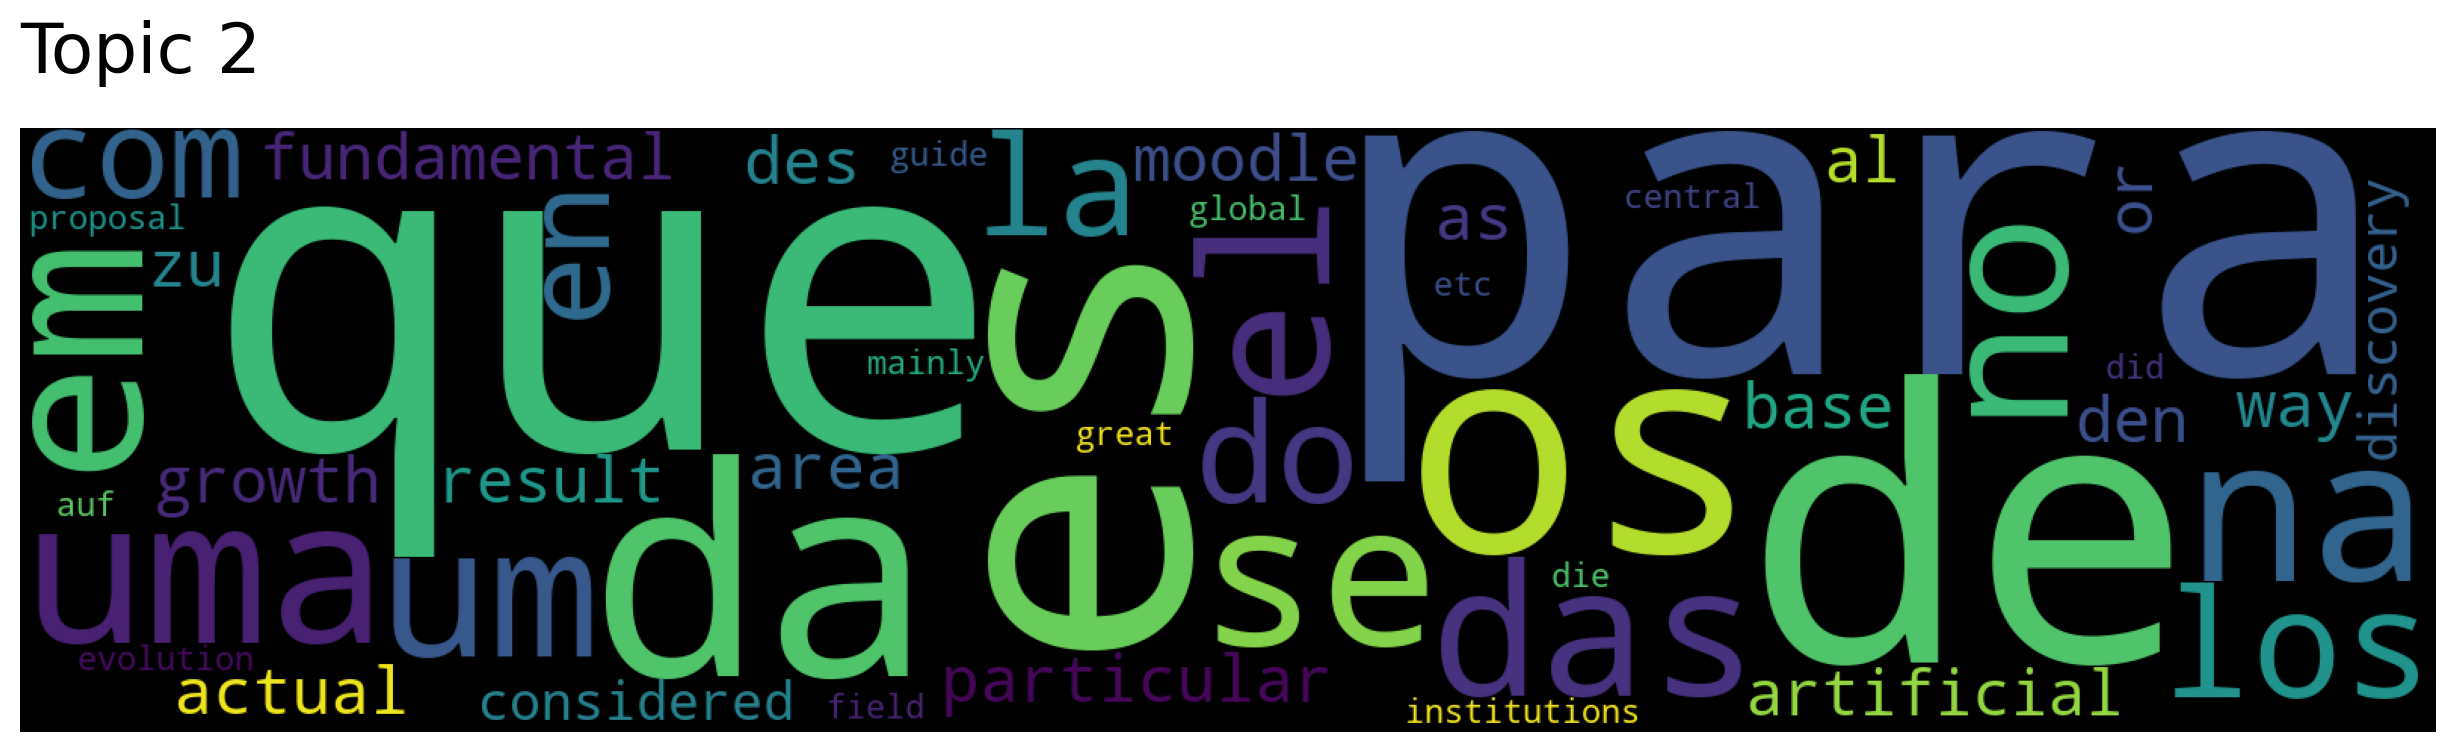

In [36]:
# Top2Vec provides some useful methods to quickly get some idea of our data:
# Get the total number of topics identified.
print("Number of Topics Identified:" + str(model.get_num_topics())+ "\n")

# Get the size of each topic, and correlating topic ID:
topic_sizes, topic_nums = model.get_topic_sizes()
print("ID of each topic: ")
print(topic_nums)
print("Number of Documents in each Topic: ")
print(topic_sizes)

# We can get the topic-words distributions:
topic_words, word_scores, topic_nums = model.get_topics()
print(topic_words)

# Or even generate a wordcloud for a specific topic ID:
model.generate_topic_wordcloud(2)




In [37]:
# Moving on, we can start to analyse our data in a bit more depth
# Here we are going to analyse and generate a visual of the relationships between each topic.

# Get topic ID for each document in our data
data["topic_id"] = model.doc_top

# Generate an embedding for every document in our data
vecs = model._get_document_vectors(norm=False)
data["embedding"] = vecs.tolist()

# Specify the topics that we want to analyse specifically using their topic-ID:
topic_list = [1,2,3,4]
# Remove any data that doesen't fit our topic-ID criteria
data = data[data["topic_id"].isin(topic_list)]

# Group our data by the assigned topic ID for each document:
grouped = data.groupby("topic_id")[["topic_id", "embedding"]]

In [38]:
nodes = []
for n, group in grouped:
    docs = []
    for doc in group["embedding"].values.tolist():
        docs.append(doc)
    nodes.append([n, docs])

In [39]:
## Define our cosine similarity calculation
## We are using NUMBA to save some time through converting the task to machine-code!
#@jit(nopython=True)
def cosine_similarity_numba(u:np.ndarray, v:np.ndarray):
    # Cosine Similarity Function using numba to drastically improve inference time
    assert(u.shape[0] == v.shape[0])
    uv = 0
    uu = 0
    vv = 0
    for i in range(u.shape[0]):
        uv += u[i]*v[i]
        uu += u[i]*u[i]
        vv += v[i]*v[i]
    cos_theta = 1
    if uu!=0 and vv!=0:
        cos_theta = uv/np.sqrt(uu*vv)
    return cos_theta


In [40]:
## Get all combinations of nodes and all combinations of cosine sim for documents between nodes. ##
from itertools import combinations, permutations
G = networkx.Graph()
for x, y in tqdm(combinations(nodes, 2)):

    sim = cosine_similarity_numba(np.mean(x[1], axis=0), np.mean(y[1], axis=0))
    print(sim)
    G.add_edge(x[0], y[0], weight = sim)


G_Filt = networkx.Graph()
for node in G.nodes():
    edges = sorted(G.edges(node, data=True), key=lambda t: t[2].get('weight', 1))
    edges = edges[-3:]
    for edge in edges:
        G_Filt.add_edge(edge[0], edge[1], weight=edge[2]["weight"])

3it [00:00, 149.86it/s]

0.48235992655738263
0.5598542529553844
0.6243558436918535


KeyError: 0

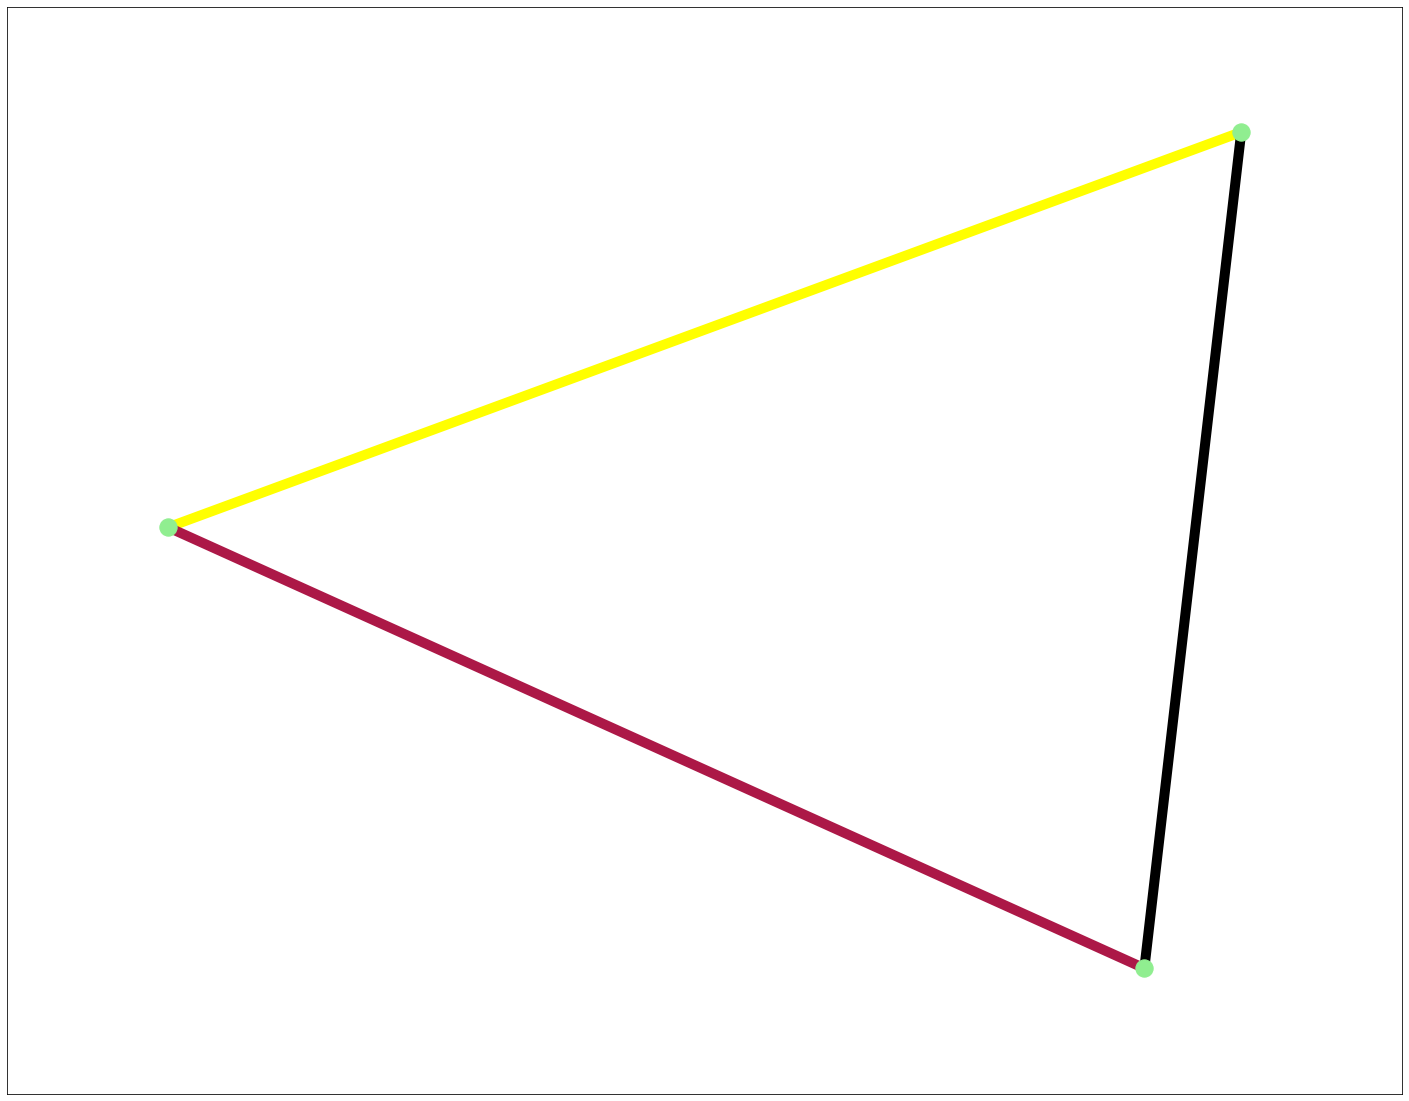

In [41]:

fig, ax = plt.subplots(figsize=(25,20))
plt.margins(0.15)
labels = {0: "AEH",2: "Intelligent Dialogue Systems",5: "Pedagogical Agents",7: "LMS",8: "CSCL",12: "MOOCs",14: "Simulations",17: "Gamification",19: "AES",28: "Recommenders"}

edges,weights = zip(*networkx.get_edge_attributes(G_Filt,'weight').items())


pos = networkx.fruchterman_reingold_layout(G_Filt)
e = networkx.draw(G_Filt, pos, node_color='lightgreen', edgelist=edges, edge_color=weights, width=10.0, edge_cmap=plt.get_cmap("gnuplot_r"), labels=labels, font_size=26, font_weight="bold")

sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("gnuplot_r"), norm=plt.Normalize(vmin = min(weights), vmax=max(weights)))
cbar = plt.colorbar(sm, ax=ax,)
cbar.ax.tick_params(labelsize=24, size=24)
cbar.set_label(label="Cosine Similarity Score", size="22")